<a href="https://colab.research.google.com/github/Last-Sage/Genetic-Programming-Forcasting/blob/main/genetic_programming_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Run this cell only once ##

!git clone https://github.com/Last-Sage/Genetic-Programming-Forcasting.git
%cd Genetic-Programming-Forcasting

Cloning into 'Genetic-Programming-Forcasting'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15 (delta 3), reused 13 (delta 1), pack-reused 0
Receiving objects: 100% (15/15), 7.35 KiB | 7.35 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/Genetic-Programming-Forcasting


In [1]:
# Run this cell to install necessary modules.

!pip install matplotlib deap numpy pandas scikit-learn

## Above cell can be skipped if modules are already installed in the system.

In [2]:
## Import modules

import csv
import random
import operator
import matplotlib.pyplot as plt
from deap import base, creator, tools, gp, algorithms
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

## Load data

This cell loads the data for training the model and testing it. Data should be provided in csv format with fields {sales, price, discount, advertisement}.

   (Add the path to files on train_data and test_data)

In [4]:
# Load training and testing data

def load_data(file_name):
    data = []
    with open(file_name, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            data.append({
                'sales': float(row['sales']),
                'price': float(row['price']),
                'discount': float(row['discount']),
                'advertisement': float(row['advertisement']),
                'cost': float(row['cost'])
            })
    return data

train_data = pd.read_csv(r"/content/Genetic-Programming-Forcasting/sample_data_for_training.csv") ## Add file path to training data csv file here
test_data = pd.read_csv(r"/content/Genetic-Programming-Forcasting/sample_data_for_testing.csv")  ## Add file path to training data csv file here

## Genetic programming settings

Adjust the basic genetic programming attributes here.

    Individual Size
    Population Size
    Number of generations

In [5]:
# Genetic programming settings
individual_size = 50
population_size = 500
generations = 15
toolbox = base.Toolbox()

pset = gp.PrimitiveSet("MAIN", 4)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.truediv, 2)

# Fields
toolbox.register("attr_price", random.uniform, -10, 10)
toolbox.register("attr_discount", random.uniform, -10, 10)
toolbox.register("attr_advertisement", random.uniform, -10, 10)
toolbox.register("attr_cost", random.uniform, -10, 10)

# Operations
toolbox.register("add", operator.add)
toolbox.register("sub", operator.sub)
toolbox.register("mul", operator.mul)
toolbox.register("div", operator.truediv)

# Function set
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=4)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


## Fitness function

In [6]:
# Fitness function
def eval_sales(individual, data):
    fitness = 0
    for sales, price, discount, advertisement, cost in zip(data['sales'], data['price'], data['discount'], data['advertisement'], data['cost']):
        code = compile(str(individual), '<string>', 'eval')
        globals_dict = {}
        locals_dict = {
            'truediv': lambda x, y: x / (y + 1e-9),
            'sub': operator.sub,
            'add': operator.add,
            'mul': operator.mul,
            'ARG0': price,
            'ARG1': discount,
            'ARG2': advertisement,
            'ARG3': cost
        }
        try:
            prediction = eval(code, globals_dict, locals_dict)
        except Exception as e:
            print("Error evaluating individual: ", e)
            prediction = 0
        fitness += (sales - prediction) ** 2
        # Add a penalty term for solutions that only use ARG0
        if 'ARG1' not in str(individual) and 'ARG2' not in str(individual) and 'ARG3' not in str(individual):
            fitness += 100
    return (fitness,)

In [7]:
# Register the fitness function
toolbox.register("evaluate", eval_sales, data=train_data)

# Register the mate, mutate, and select functions
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=100) ## Edit 'tournsize' to specify the tournament size


## Functions for visualisation

Function to visualise training data and predictions on trained data. modify this section to change graph type, colours, legend or other related settings.

In [8]:
def visualize_data(data, title):
    plt.scatter(data['price'], data['discount'], c=data['sales'])
    plt.xlabel('Price')
    plt.ylabel('Discount')
    plt.title(title)
    plt.show()

def visualize_predictions(actual, predicted, title):
    plt.plot(actual, label='Actual Sales')
    plt.plot(predicted, label='Predicted Sales')
    plt.xlabel('Index')
    plt.ylabel('Sales')
    plt.title(title)
    plt.legend()
    plt.show()

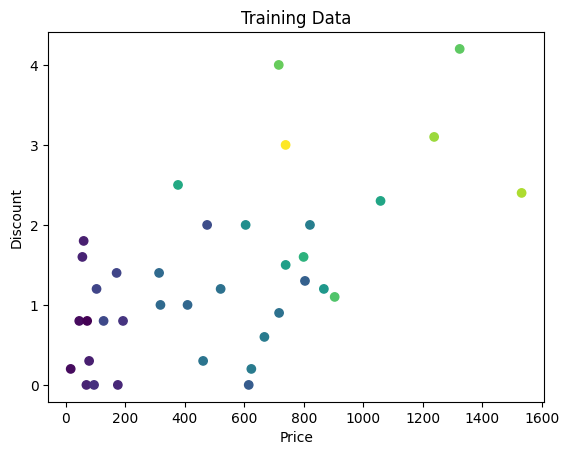

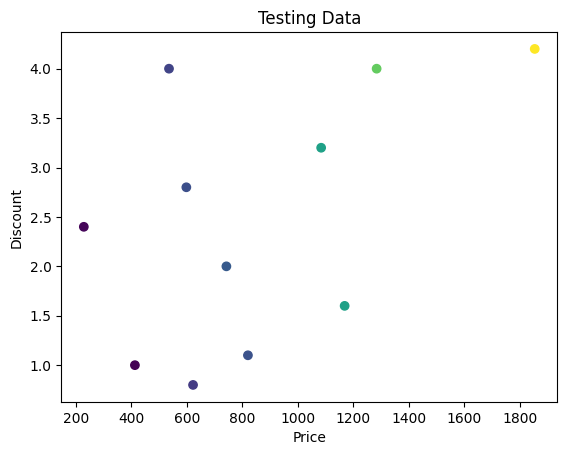

In [9]:
## Visualize the training data and testing data

# This cell is only for visualising the training data if necessary.

visualize_data(train_data, 'Training Data')
visualize_data(test_data, 'Testing Data')

## Run the Genetic Programming

To set the crossover probabilty edit the 'cxpb' variable.
To set mutation probability edit 'mutpb' variable.
Rest of the percentage remaining after setting crossover and mutation is selected as elite probability.

In [10]:
def main():
    random.seed(64)

    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Avg", np.mean)
    stats.register("Std", np.std)
    stats.register("Min", np.min)
    stats.register("Max", np.max)

    ## Edit here to set crossover, mutation annd elite probability
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.8, mutpb=0.1, ngen=generations, stats=stats, halloffame=hof, verbose=True)

    print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))

    return pop, log, hof

if __name__ == "__main__":
    pop, log, hof = main()
    # print ('hof is ', hof)

# Predict sales using the best individual on test_data
def predict_sales(best_individual, data):
    predictions = []
    for price, discount, advertisement, cost in zip(data['price'], data['discount'], data['advertisement'], data['cost']):
        code = compile(str(best_individual), '<string>', 'eval')
        globals_dict = {'truediv': lambda x, y: x / (y + 1e-9),
                        'sub': operator.sub,
                        'add': operator.add,
                        'mul': operator.mul}
        locals_dict = {'ARG0': price, 'ARG1': discount, 'ARG2': advertisement, 'ARG3': cost}
        try:
            prediction = eval(code, globals_dict, locals_dict)
        except Exception as e:
            print("Error predicting sales: ", e)
            prediction = 0
        predictions.append(prediction)
    return predictions

gen	nevals	Avg        	Std        	Min    	Max        
0  	500   	1.45684e+50	3.25431e+51	8035.46	7.28414e+52
1  	397   	8.4527e+38 	1.8857e+40 	4509.88	4.22078e+41
2  	419   	2.87564e+26	6.4237e+27 	4509.88	1.43782e+29
3  	397   	6.5167e+24 	1.42514e+26	4509.88	3.18931e+27
4  	398   	2.87564e+44	6.4237e+45 	4509.88	1.43782e+47
5  	412   	1.18017e+44	2.63631e+45	4353.07	5.90087e+46
6  	411   	6.07901e+49	1.35795e+51	4178.15	3.0395e+52 
7  	413   	2.31382e+23	4.58019e+24	4065   	1.01994e+26
8  	405   	3.93758e+21	3.88878e+22	4045.39	4.33477e+23
9  	400   	1.82071e+23	2.74599e+24	3979.56	5.75128e+25
10 	411   	8.46823e+27	1.89162e+29	3930.39	4.23404e+30
11 	409   	4.43354e+28	9.90176e+29	3882.8 	2.21632e+31
12 	406   	8.2166e+38 	1.83545e+40	3867.28	4.1083e+41 
13 	408   	2.29933e+40	5.05199e+41	3809.58	1.13067e+43
14 	422   	2.91272e+26	6.5064e+27 	3749.64	1.45633e+29
15 	405   	1.3265e+26 	2.96301e+27	3505.98	6.63213e+28
Best individual is: add(ARG2, sub(add(add(ARG0, add(ARG2, truediv

## Predict sales on test_data

Using the best generated individual got from training the genetic programming model with training data.

In [11]:
# Predict sales
predictions = predict_sales(hof[0], test_data)
actual_sales = test_data['sales']


## Plot the predictions

As bar line graph using visualise function

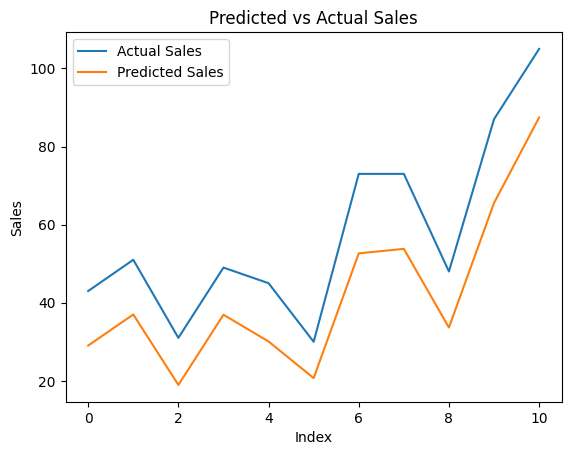

In [12]:
# Visualize the predictions
visualize_predictions(actual_sales, predictions, 'Predicted vs Actual Sales')

## Analyse the results

Analyse the prediction with various error metrics

In [13]:
# Compare predicted sales with actual sales in test_data
mse = ((actual_sales - predictions) ** 2).mean()
r2 = r2_score(actual_sales, predictions)
mae = np.mean(np.abs(actual_sales - predictions))
rmse = np.sqrt(np.mean((actual_sales - predictions) ** 2))
mpe = np.mean(np.abs((actual_sales - predictions) / actual_sales)) * 100
mape = np.mean(np.abs((actual_sales - predictions) / actual_sales)) * 100
rmspe = np.sqrt(np.mean(((actual_sales - predictions) / actual_sales) ** 2)) * 100
cv = np.std(predictions) / np.mean(predictions)


print(f"Mean squared error between predicted and actual sales: {mse}")
print(f"R-squared value between predicted and actual sales: {r2}")
print(f"MAE between predicted and actual sales: {mae}")
print(f"RMSE between predicted and actual sales: {rmse}")
print(f"MPE between predicted and actual sales: {mpe}%")
print(f"MAPE between predicted and actual sales: {mape}%")
print(f"RMSPE between predicted and actual sales: {rmspe}%")
print(f"CV of prediction: {cv}")

Mean squared error between predicted and actual sales: 249.9749090212802
R-squared value between predicted and actual sales: 0.5121300043295767
MAE between predicted and actual sales: 15.387571084718212
RMSE between predicted and actual sales: 15.810594834517778
MPE between predicted and actual sales: 28.46549878202197%
MAPE between predicted and actual sales: 28.46549878202197%
RMSPE between predicted and actual sales: 28.984242461700315%
CV of prediction: 0.4661963368272676
